In [29]:
from operator import xor
from pickle import FALSE
#import matlab.engine
#import matlab
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.style.use('seaborn-poster')
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib import gridspec
import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fft as sft
import scipy.interpolate as spi
import pywt
import matplotlib as mpl
from obspy.signal.detrend import polynomial
import h5py
import pathlib as pl
import os
from math import ceil, pi, sqrt, log 
import pickle
from brokenaxes import brokenaxes
from adjustText import adjust_text
from decimal import Decimal
from cal_intensity import cal_intensity
#from pynufft import NUFFT

my_path = os.getcwd()

mpl.rcParams['lines.linewidth'] = 1
plt.rcParams["font.family"] = "arial"
#mpl.rcParams['mathtext.fontset'] = 'custom'
#mpl.rcParams['mathtext.it'] = 'Arial:italic'
#mpl.rcParams['mathtext.rm'] = 'Arial'

SMALL_SIZE = 22
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def save_obj(obj, filename):
    with open(filename, 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

class FFT_ionS():
    #def __init__(self, filename, massRange=[5, 90], dcRange=2, cal_mass=[45,61], cal_pixel=[415,1141]):
    def __init__(self, filename, scanTime, sampRate, massRange=[5, 50], molecule='H2', intensity = 0, dcRange=2, ChN=10):
    #def __init__(self, filename, massRange=[5, 50], dcRange=2, cal_mass=[17,18], cal_pixel=[494,583]):
    #def __init__(self, filename, massRange=[5, 50], dcRange=2, cal_mass=[17,18], cal_pixel=[197,279]):
        '''

        '''
        self.filename = filename
        self.filepath = []
        self.rootPath= pl.PureWindowsPath(r'C:\Users\user\Desktop\Data_newTOF')
        self.channelSize = 1024
        self.scanTime = scanTime
        self.trueScanTime = ceil(self.scanTime/1.6)*1.6
        self.scanLength = self.scanTime*sampRate
        self.peakRange = [-15, 15]  # range of the peak
        #self.delay = np.arange(self.scanLength)/self.scanLength*(self.trueScanTime-0.7/self.trueScanTime)*100*2*2*3.33564*10**-15
        self.delay = np.arange(self.scanLength)/self.scanLength*((self.scanTime)/self.trueScanTime)*99*2*2*3.33564*10**-15
        self.rebin_delay = None
        self.ifrebin = False
        self.longstage = True
        self.data = 0
        self.massRange = massRange
        self.dcRange = dcRange
        self.spectraBottle = {}
        self.interSpectraBottle = {}
        self.fftS = {}
        self.stftS = {}
        self.waveletsCoe = {}
        self.spec = None
        self.scanNo = None
        self.ChN = ChN
        self.molecule = molecule
        self.intensity = intensity
        self.stage = 'piezo'

        

    def pathFinder(self):
        for fn in self.filename:
            interpath = pl.PureWindowsPath(fn[9:16], fn[9:19])
            self.filepath = self.filepath + [pl.PureWindowsPath(self.rootPath, interpath, fn + r'.hdf5')]
            #self.exportPath = pl.PureWindowsPath(self.rootPath, interpath, r'plot')
            self.exportPath = pl.PureWindowsPath(r'C:\Users\user\Desktop\Data_newTOF\plotdata')
            
        if not os.path.exists(x.exportPath):
            os.mkdir(x.exportPath)

    def checkData(self):
        with h5py.File(self.filename, 'r+') as f:
            print(np.array(f['parameters']))
    
    def combineData(self):
        pass

    def read_split(self):
        
        ChN=self.ChN #number of channels measured
        zeroIndex = []
        for i in range(ChN):
            x.spectraBottle['Ch'+str(i)] = 0
        for fp in self.filepath:
            with h5py.File(fp, 'r+') as f:
                #print(f.keys())
                data = np.array(f['data'], dtype=float)
                #print(data.shape)
                for i in range(ChN):
                        self.interSpectraBottle['Ch'+str(i)] = np.sum(data[i::ChN][2:],0)
                        #iii=data[i::ChN]
                        #for i in range(1,5):
                        #    plt.plot(iii[i*3])
                        #plt.show()
                        #self.spectraBottle['Ch'+str(i)] = self.interSpectraBottle['Ch'+str(i)]+self.spectraBottle['Ch'+str(i)]
                zeroIndex+=[self.findZeroDelay()]
        zeroIndexS=zeroIndex
        zeroIndexS.sort()
        zeroIndexMin = zeroIndexS[0]
        zeroIndexMax = zeroIndexS[-1]
        for fp in self.filepath:
            fn=0
            with h5py.File(fp, 'r+') as f:
                #print(f.keys())
                data = np.array(f['data'], dtype=float)
                #print(data.shape)
                for i in range(ChN):
                        self.interSpectraBottle['Ch'+str(i)] = np.sum(data[i::ChN][2:],0)
                        self.spectraBottle['Ch'+str(i)] = self.spectraBottle['Ch'+str(i)] + self.interSpectraBottle['Ch'+str(i)][(zeroIndex[fn]-zeroIndexMin):(self.scanLength-(zeroIndexMax-zeroIndex[fn]))]
                        if fn == 0:
                            self.spectraBottle['Ch'+str(i)] = 1*self.spectraBottle['Ch'+str(i)]
                #for i in range(ChN):
                #    if np.sum(self.spectraBottle['Ch'+str(i)])==0 or self.interSpectraBottle['Ch'+str(i)].size==self.spectraBottle['Ch'+str(i)].size:
                #       self.spectraBottle['Ch'+str(i)] = self.spectraBottle['Ch'+str(i)] + self.interSpectraBottle['Ch'+str(i)]
                #    elif self.interSpectraBottle['Ch'+str(i)].size > self.spectraBottle['Ch'+str(i)].size:
                #        interL=self.spectraBottle['Ch'+str(i)].size
                #        self.spectraBottle['Ch'+str(i)] = self.spectraBottle['Ch'+str(i)] + self.interSpectraBottle['Ch'+str(i)][:interL]
                #    else:
                #        interL=self.interSpectraBottle['Ch'+str(i)].size
                #        self.spectraBottle['Ch'+str(i)] = self.spectraBottle['Ch'+str(i)][:interL] + self.interSpectraBottle['Ch'+str(i)]
            fn+=1
        delayStep = self.delay[1]-self.delay[0]
        
        self.delay = (np.arange(self.spectraBottle['Ch'+str(0)].size)-zeroIndexMin)*delayStep
        
        add = lambda i,j, m: self.spectraBottle['Ch'+str(i)]+self.spectraBottle['Ch'+str(j)]*m
        sub = lambda i,j: self.spectraBottle['Ch'+str(i)]-self.spectraBottle['Ch'+str(j)]
        
        #x.spectraBottle['Ch2+8'] = add(2,8,1)#'Mass1+Mass2','Mass1+Mass16', 'Mass1+Mass17', 'Mass16+Mass17','Mass17+Mass18',
        #x.spectraBottle['Ch0+2'] = add(0,2,10)
        #x.spectraBottle['Ch0+3'] = add(0,3,1)
        #x.spectraBottle['Ch2-6'] = add(2,6,-10)
        #x.spectraBottle['Ch3+4'] = add(3,4,1)

    def adjustJointAmp(self,traceA,traceB):
        #plt.plot(traceA[:-300])
        #plt.show()
        #ampA = np.amax(traceA[:-300])-np.amin(traceA[:-300])
        #ampB = np.amax(traceB[:-300])-np.amin(traceB[:-300])
        #traceB = traceB*(ampA/ampB)
        return np.append(traceA, traceB)

    def adjustJointDelay(self):
        pass

    def read_split_slidingWindow(self, numRange=45, numEff=37, shift=0):
        ChN=self.ChN #number of channels measured
        delayStep = self.delay[1]-self.delay[0]
        #print(self.delay[-1]*1e15)
        numOverLay=int((self.delay[-1]-1134.1178*1e-15)/2/delayStep)+shift
        #print(numOverLay)
        for i in range(ChN):
            x.spectraBottle['Ch'+str(i)] = 0
        for fp in self.filepath:
            with h5py.File(fp, 'r+') as f:
                #print(f.keys())
                data = np.array(f['data'], dtype=float)
                data = data[:37800]
                #print(data.shape)
                L = data.shape[1]
                data = data.reshape((numRange,int(data.shape[0]/numRange),data.shape[1]))
                #print(data.shape)
                #self.data = np.concatenate(tuple([data[0,:,:(L-numOverLay)] if i==0 else data[i,:,numOverLay:L-numOverLay] for i in range(numRange)]),axis=1)
                
                for i in range(ChN):
                    for j in range(numRange):
                        self.interSpectraBottle['Ch'+str(i)+str(j)] = np.sum(data[j,i::ChN,:],0)
                        #plt.plot(self.interSpectraBottle['Ch'+str(i)+str(j)])
                        #plt.show()
                        if j==0:
                            pass#self.spectraBottle['Ch'+str(i)] = polynomial(self.interSpectraBottle['Ch'+str(i)+str(j)][1000:(L-numOverLay[j])], order=1, plot=False)
                        elif j==1:
                            #hwindow = np.hanning(len(self.interSpectraBottle['Ch'+str(i)+str(j)][1000:(L-numOverLay)]))#sps.windows.flattop(len(window),sym=FALSE)
                            #self.spectraBottle['Ch'+str(i)] = polynomial(self.interSpectraBottle['Ch'+str(i)+str(j)][:(L-numOverLay)], order=5, plot=False)#*hwindow
                            self.spectraBottle['Ch'+str(i)] = self.interSpectraBottle['Ch'+str(i)+str(j)][:(L-numOverLay)]#*hwindow
                        elif j<=numEff:
                            #hwindow = np.hanning(len(self.interSpectraBottle['Ch'+str(i)+str(j)][numOverLay:(L-numOverLay)]))
                            #self.spectraBottle['Ch'+str(i)]=self.adjustJointAmp(self.spectraBottle['Ch'+str(i)],polynomial(self.interSpectraBottle['Ch'+str(i)+str(j)][numOverLay:(L-numOverLay)], order=5, plot=False))
                            self.spectraBottle['Ch'+str(i)]=self.adjustJointAmp(self.spectraBottle['Ch'+str(i)],self.interSpectraBottle['Ch'+str(i)+str(j)][numOverLay:(L-numOverLay)])
                
                        #iii=data[i::ChN]
                        #for i in range(1,5):
                        #    plt.plot(iii[i*3])
                        #plt.show()
                #for i in range(ChN):
                #    for j in range(numRange):
                        
                            #self.spectraBottle['Ch'+str(i)] = np.concatenate(tuple([polynomial(self.interSpectraBottle['Ch'+str(i)+str(j)][numOverLay:(L-numOverLay)], order=5, plot=False) if i==0 else polynomial(self.interSpectraBottle['Ch'+str(i)+str(j)][numOverLay:L-numOverLay], order=5, plot=False) for j in range(numRange)]), axis=0)
                            
                            #self.spectraBottle['Ch'+str(i)] = self.spectraBottle['Ch'+str(i)].append(tuple([self.interSpectraBottle['Ch'+str(i)+str(j)][numOverLay:(L-numOverLay)] if i==0 else self.interSpectraBottle['Ch'+str(i)+str(j)][numOverLay:L-numOverLay]]), axis=0)
                            #self.spectraBottle['Ch'+str(i)] = np.concatenate(tuple([polynomial(self.interSpectraBottle['Ch'+str(i)+str(j)][numOverLay:L-numOverLay], order=1, plot=False) for j in range(numRange) if j>0]), axis=0)
                
                
        zeroIndex=self.findZeroDelay()
        self.delay = (np.arange(self.spectraBottle['Ch'+str(0)].size)+self.interSpectraBottle['Ch'+str(0)+str(0)].size)*delayStep
        
        add = lambda i,j, m: self.spectraBottle['Ch'+str(i)]+self.spectraBottle['Ch'+str(j)]*m
        sub = lambda i,j: self.spectraBottle['Ch'+str(i)]-self.spectraBottle['Ch'+str(j)]
        
        #x.spectraBottle['Ch2+8'] = add(2,8,1)#'Mass1+Mass2','Mass1+Mass16', 'Mass1+Mass17', 'Mass16+Mass17','Mass17+Mass18',
        #x.spectraBottle['Ch0+2'] = add(0,2,10)
        #x.spectraBottle['Ch0+3'] = add(0,3,1)
        x.spectraBottle['Ch2+6'] = add(2,6,1)
        #x.spectraBottle['Ch3+4'] = add(3,4,1)

    def FFT(self, t, y): #https://www.researchgate.net/post/What-are-the-basic-differences-between-FFT-and-DFT-and-DCT
        n = len(t)
        delta = (max(t) - min(t)) / (n)
        f = sft.fftshift(sft.fftfreq(n, delta))/ 10**12  # frequency unit THz
        fft_y = sft.fftshift(sft.fft(y))
        fft_y = fft_y/np.mean(np.abs(fft_y))
        Y = np.abs(fft_y)
        Y_r = np.real(fft_y)
        Y2 = np.where(Y<np.mean(Y)*0,0,fft_y)
        #plt.plot(np.abs(Y2))
        #plt.show()
        P = np.angle(Y2)
        return np.array([f, fft_y, P])

    def window(self, windowSize=0, direction='left'):
        '''
        windowSize is in fs.
        '''
        self.windowSize = windowSize
        for gas in list(self.spectraBottle):
            #print(gas)
            if 'rebin' not in gas:
                self.spectraBottle[gas], self.spectraBottle['window_'+gas], self.delay = self.inter_window(gas, self.delay, windowSize=windowSize, direction=direction)
            else:
                self.spectraBottle[gas], self.spectraBottle['window_rebin_'+gas], self.rebin_delay = self.inter_window(gas, self.rebin_delay, windowSize=windowSize, direction=direction)
            
    def inter_window(self, gas, delay, windowSize=0, direction='left'):
        '''
        windowSize is in fs.
        '''
        data = self.spectraBottle[gas]
        __len = np.size(data)
        windowSize = int(windowSize/(delay[1]-delay[0])*1e-15)
        #print((delay[1]-delay[0]))
        if direction == 'left':
            window = data[-(__len-windowSize):]
            delay = delay[-(__len-windowSize):]
        elif direction == 'right':
            window = data[:__len-windowSize]
            delay = delay[:__len-windowSize]
        elif direction == 'middle':
            window = np.concatenate((
                data[:round((__len-windowSize)/2)],  # need to check again
                (data[round((__len-windowSize)/2)] + \
                 data[round((__len+windowSize)/2)])/2*(np.zeros(windowSize)+1),
                data[-(__len-round((__len+windowSize)/2)+1):]
            ))
            #self.paddedDelay = np.arange(self.delay[0])
        # if (stepNum_left%2) == 0:
        #    paddingWindow = np.concatenate(( np.zeros(int(stepNum_left/2))+1,
        #    np.zeros(windowSize*2),np.zeros(int(stepNum_left/2))+1,np.zeros(paddingSize)))
        #    #self.paddedDelay = np.arange(self.delay[0])
        # else:
        #    paddingWindow = np.concatenate((np.zeros(paddingSize), np.zeros(int((stepNum_left-1)/2))+1,
        #    np.zeros(windowSize*2),np.zeros(int((stepNum_left+1)/2))+1, np.zeros(paddingSize)))
            # plt.plot(dcShift)
        window=polynomial(window, order=1, plot=False)
        hwindow = np.hanning(len(window))#sps.windows.flattop(len(window),sym=FALSE)
        window2=window*hwindow #https://stackoverflow.com/questions/55654699/how-to-get-correct-phase-values-using-numpy-fft
        
        return window, window2, delay

    def padding(self, paddingSize=0):
        for gas in self.spectraBottle.keys():
            if "rebin" not in gas:
                self.spectraBottle[gas], self.delay = self.inter_padding(gas, self.delay, paddingSize = paddingSize)
            else:
                self.spectraBottle[gas], self.rebin_delay = self.inter_padding(gas, self.rebin_delay, paddingSize = paddingSize)

    def inter_padding(self, gas, delay, paddingSize=0):
        data = None
        delayStep = delay[90]-delay[89]
        delay = np.concatenate((
            #np.arange(delay[0]-(paddingSize+1) *
            #          delayStep, delay[0], delayStep),
            delay,
            np.arange(delay[-1]+delayStep, delay[-1] +
                      (paddingSize)*delayStep, delayStep)
        ))
        inter_data = self.spectraBottle[gas]
        data = np.concatenate(
            #(np.zeros(paddingSize)+inter_data[0], inter_data, np.zeros(paddingSize)+inter_data[-1]), axis=0)
            (inter_data, (np.zeros(paddingSize))), axis=0)
        delay = delay[:len(data)]
        return data, delay

    def interpS(self, interNum=1):
        interpDelay = np.arange(
            self.delay[0], self.delay[-1], (self.delay[1]-self.delay[0])/(interNum+1))
        for gas in self.spectraBottle.keys():
            iS = np.interp(interpDelay, self.delay, self.spectraBottle[gas])
            self.spectraBottle[gas] = iS
            # print(np.shape(iS))
        self.delay = interpDelay

    def FFTS(self):
        for gas in self.spectraBottle.keys():
            if "rebin" not in gas:
                delay = self.delay
                self.fftS[gas] = self.FFT(
                    delay, self.spectraBottle[gas])
            else:
                delay = self.rebin_delay
                self.fftS[gas] = self.FFT(
                    delay, self.spectraBottle[gas])

    def rmvExp(self):
        for gas in self.spectraBottle.keys():
            #y = self.spectraBottle[gas]
            #k, b = np.polyfit(self.delay, np.log(y), 1)#, w=np.sqrt(y))
            #self.spectraBottle[gas] = y- np.exp(b)*np.exp(self.delay*k)
            self.spectraBottle[gas]=polynomial(self.spectraBottle[gas], order=3, plot=False)

    def runingAverage(self, n=5):
        def runAve(x, N): return np.convolve(x, np.ones(N)/N, mode='valid')
        for gas in self.spectraBottle.keys():
            self.spectraBottle[gas] = runAve(self.spectraBottle[gas], n)
            new_size = len(self.spectraBottle[gas])
        self.delay = self.delay[:new_size]

    def smooth(self, windowSize=100, order=3):
        for gas in self.spectraBottle.keys():    
            self.spectraBottle[gas]=sps.savgol_filter(self.spectraBottle[gas], windowSize, order) # window size 51, polynomial order 3
    
    def rebin_factor(self, a, factor):
            '''Rebin an array to a new shape.
            newshape must be a factor of a.shape.
            '''
            newshape = tuple(int(i/factor) for i in a.shape)
            i1 = tuple(int(i*factor) for i in newshape)
            a = a[:i1[0]]
            return a.reshape(newshape+(-1,)).mean(axis=-1)
    
    def rebinS(self, factor=10):
        self.ifrebin = True
        for gas in list(self.spectraBottle.keys()):
            self.spectraBottle['rebin_'+gas] = self.rebin_factor(self.spectraBottle[gas], factor)
        self.rebin_delay = self.rebin_factor(self.delay, factor)

    def dataProcess(self):
        #self.mass_spectra()
        self.FFTS()

    def useFilter(self, lowcut, highcut, comFre):
        for gas in list(self.spectraBottle.keys()):
            # if 'rebin' not in gas:
            fs = 1/(self.delay[1]-self.delay[0])
            # else:
            #     fs = 1/(self.rebin_delay[90]-self.rebin_delay[89])
            self.spectraBottle['filter_'+gas] = self.butter_bandpass_filter(self.spectraBottle[gas], lowcut, highcut, fs)
            self.spectraBottle['comfil_'+gas] = self.butter_bandpass_filter(self.spectraBottle[gas], comFre[0]/33.35641*1e12, comFre[1]/33.35641*1e12, fs)

    def butter_bandpass_filter(self, data, lowcut, highcut, fs, order=2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = sps.butter(order, [low, high], analog=False, btype='band', output='sos')
        y = sps.sosfiltfilt(sos, data)
        #w, h = sps.sosfreqz(sos, worN=2000)
        #plt.plot(w, h)
        #plt.show()
        return y

    def findZeroDelay(self):
        self.sumSpec=0
        for gas in list(self.interSpectraBottle.keys()):
            self.sumSpec = self.sumSpec+self.interSpectraBottle[gas]
        if len(self.sumSpec.shape)==1:
            self.sumSpec=self.butter_bandpass_filter(self.sumSpec, 100/33.35641*1e12, 3000/33.35641*1e12, 1/(self.delay[1]-self.delay[0]))
        else:
            self.sumSpec=self.butter_bandpass_filter(self.sumSpec[0], 100/33.35641*1e12, 3000/33.35641*1e12, 1/(self.delay[1]-self.delay[0]))
        zeroIndex = np.abs(self.sumSpec).argmax()
        #print(zeroIndex)
        #plt.plot(self.sumSpec)
        #plt.show()
        #zeroIndexInput = input()
        #zeroIndex = int(zeroIndexInput)
        for gas in list(self.interSpectraBottle.keys()):
            self.interSpectraBottle[gas] = self.interSpectraBottle[gas][zeroIndex:]
        #self.delay = self.delay[zeroIndex:]-self.delay[zeroIndex]
        return zeroIndex

    def show_FFT(self):
        self.dcRange=0
        #gs = gridspec.GridSpec(2, 3)
        fig = plt.figure(figsize=(12,6))
        lab=['Mass 1','Mass 2','Mass 16','Mass 17','Mass 18','Mass1+Mass2','Mass1+Mass16', 'Mass1+Mass17', 'Mass16+Mass17','Mass17+Mass18']
        #threshold=[0,0,0,0.1,0]#one hour measurement
        #height=[1,0.5,0.5,3,30]
        #threshold=[0.1,0,0,0,0]
        #height=[10,10,10,10,10]
        #distance=[5,5,5,5,30]
        i=0
        ax = fig.add_subplot(111)
        for gas in self.fftS.keys():
            if 'filter' in gas  or 'window' in gas or 'rebin' in gas or 'com' in gas:
                continue
            
            label=lab[i]
            i=i+1
            if self.ChN == 10:
                if gas not in ['Ch0','Ch6','Ch8']:
                    continue
            if self.ChN == 5:
                if gas not in ['Ch0','Ch3','Ch4']:
                    continue
            

            [f, Y, _] = self.fftS[gas]
            [f_window, Y_window, P_window] = self.fftS['window_'+gas]
            #[f_rebin, Y_rebin, P_rebin] = self.fftS['rebin_'+gas]
            plotRatio=1
            f=f.astype(float)*33.35641
            #f_rebin=f_rebin*33.35641
            Y=np.where(np.logical_and(f>=10, f<=4500),Y,0)/plotRatio
            #peaks, _ = sps.find_peaks(Y, height=height[i], threshold=threshold[i], width=0)
            #ax.plot(f,np.abs(Y), label=label)#gas)#, label=self.trueScanTime)
            #ax.plot(f,np.abs(Y_filter)/20, label='filter'+label)#gas)#, label=self.trueScanTime)
            ax.plot(f, np.abs(Y_window), label=label)#gas)#, label=self.trueScanTime)
            #ax.plot(f_rebin,np.abs(Y_rebin), label='rebin_window_'+label)#gas)#, label=self.trueScanTime)
            #ax.plot(f,np.real(Y), label="Re")#gas)#, label=self.trueScanTime)
            #ax.plot(f,np.imag(Y), label="Im")#gas)#, label=self.trueScanTime)
            #axP.plot(f,P_filter/np.pi+1,'r')
            #peaksIndex = [[59656],[58971,59168,59195,59219,59246,59273,59656,59770],[58913,59494,59656],[59196,59656],[59196,59138,58957,59020,59656]]
            #peaksIndex = [[59574],[59574,59687],[],[59574],[59574]]
            #ax.plot(f[peaksIndex[i]],np.abs(Y_window)[peaksIndex[i]], "rx")
            texts = []
            #for x, y in zip(f[peaksIndex[i]],np.abs(Y_window)[peaksIndex[i]]):
            #    texts.append(plt.text(x, y, str(int(x)), color="red", fontsize=10))
                #ax.text(x,y, str(int(x)), color="red", fontsize=10)
            ax.set_xlabel(r'$\mathrm{Frequency (cm^{-1})}$')
            ax.set_ylabel('Count (a.u.)')
            #axP.set_ylabel('Phase/pi')
            ax.legend(loc=2)
            #ax.set_ylim([0,15])

            ax.set_xlim([0,4500])
            #adjust_text(texts, only_move={'points':'y'})
            #ax.set_xlim([58870,59920])
            #ax.set_title(gas)
            
            np.savetxt(pl.PureWindowsPath(self.exportPath, str('FFT')+label+self.molecule+str('%.1E' % Decimal(self.intensity))+str('.dat')), np.abs(Y_window))
            np.savetxt(pl.PureWindowsPath(self.exportPath, str('FFT')+label+self.molecule+str('%.1E' % Decimal(self.intensity))+str('frequency')+str('.dat')), f)
        plt.legend()
        fig.tight_layout()
        d='_80pp_240pr'
        plt.savefig('20220214_'+"fft_"+d,dpi=720, bbox_inches='tight', pad_inches=0.05)

    def show_FFT_comp(self):
        gs = gridspec.GridSpec(1, 3)
        fig = plt.figure(figsize=(15,5))
        lab=['Mass 1','Mass 2','Mass 16','Mass 17','Mass 18','Mass1+Mass2','Mass1+Mass16', 'Mass1+Mass17', 'Mass16+Mass17','Mass17+Mass18']
        #threshold=[0,0,0,0.1,0]#one hour measurement
        #height=[1,0.5,0.5,3,30]
        threshold=[0,0.005,0.01,0.1,0.08]
        height=[20,2,0.8,100,8]
        distance=[5,5,5,5,30]
        i=0
        j=0
        for gas in self.fftS.keys():
            label=lab[i]
            [f, Y] = self.fftS[gas]
            plotRange=int(np.size(f)/50)
            plotRatio=100
            f=f[self.dcRange:plotRange]*33.35641
            Y=Y[self.dcRange:plotRange]/plotRatio
            
            if gas == "Ch0":
                ax = fig.add_subplot(gs[j])
                [fc,Yc]=self.fftS["Ch0+1"]
                Yc=Yc[self.dcRange:plotRange]/plotRatio
                ax.plot(f, Yc, label="Mass1+Mass2")
                [fc,Yc2]=self.fftS["Ch0+2"]
                Yc2=Yc2[self.dcRange:plotRange]/plotRatio
                ax.plot(f, Yc2, label="Mass1+Mass16")
                j=j+1
            elif gas== "Ch3":
                ax = fig.add_subplot(gs[j])
                [fc,Yc]=self.fftS["Ch0+3"]
                Yc=Yc[self.dcRange:plotRange]/plotRatio
                ax.plot(f, Yc, label="Mass1+Mass17")
                j=j+1
            elif gas== "Ch4":
                ax = fig.add_subplot(gs[j])
                [fc,Yc]=self.fftS["Ch3+4"]
                Yc=Yc[self.dcRange:plotRange]/plotRatio
                ax.plot(f, Yc, label="Mass17+Mass18")
                j=j+1
            else:
                i=i+1
                continue

            ax.plot(f, Y, label=label)
            #peaks, _ = sps.find_peaks(Y, height=height[i], threshold=threshold[i], width=3, distance=distance[i])
            #gas)#, label=self.trueScanTime)
            #ax.plot(f[peaks],Y[peaks], "rx")
            #for x, y in zip(f[peaks],Y[peaks]):
            #    plt.text(x+50,y, str(int(x)), color="red", fontsize=10)
            ax.set_xlabel('Frequency/cm-1')
            ax.set_ylabel('a.u.')
            ax.legend()
            #ax.set_ylim([0,np.max(Y[self.dcRange:8000])*1/200])
            ax.set_xlim([0,4500])
            #ax.set_title(gas)
            i=i+1
        plt.legend()
        fig.tight_layout()
        d='_270pp_260pr'
        #plt.savefig("fft_31"+d,dpi=720, bbox_inches='tight', pad_inches=0.2)

    def show_Spectra(self, shift=0):
        #gs = gridspec.GridSpec(2, 3)
        gs = gridspec.GridSpec(1, 1)
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111)
        lab=['Mass1','Mass2','Mass16','Mass17','Mass18','Ch2-Ch6','Mass1+Mass16', 'Mass1+Mass17', 'Mass16+Mass17','Mass17+Mass18']
        i=0
        for gas in self.spectraBottle.keys():
            print(gas)
            #if 'rebin' not in gas or 'filter' not in gas:
            if 'filter' in gas or 'window' in gas or 'rebin' in gas or 'com' in gas:
                continue
            #elif 'rebin' not in gas:
            label=lab[i]
            i=i+1
            if self.ChN == 10:
                if gas in ['Ch0','Ch6','Ch8']:
                    pass
                else:
                    print('Skip!')
                    continue
            elif self.ChN == 5:
                if gas in ['Ch3','Ch4']:
                    pass
                else:
                    continue
                    
            
            if gas=='Ch0':
                self.spectraBottle[gas]=self.spectraBottle[gas]
            if gas=='Ch3':
                self.spectraBottle[gas]=self.spectraBottle[gas]*50

            
            
            delay = self.delay
            rebindelay = self.rebin_delay
            #else:
            #    delay = self.rebin_delay
            ax.plot(delay*10**15+shift,
                     self.spectraBottle[gas], label=label)#/np.amax(self.spectraBottle[gas])
            #ax.plot(delay*10**15+shift,
            #         self.spectraBottle['window_filter_'+gas], label=label)
            #ax.plot(delay*10**15+shift,
                     #self.spectraBottle['window_'+gas], label='window_'+gas)
            #ax.plot(rebindelay*10**15+shift,
            #         self.spectraBottle['rebin_window_'+gas], label='rebin_window_'+gas)      

            ax.set_xlabel("Delay/fs")
            ax.set_ylabel('a.u.')
            #plt.xlim([300,400])
            ax.legend()
            np.savetxt(pl.PureWindowsPath(self.exportPath, str('Time')+label+self.molecule+self.stage+str('%.1E' % Decimal(self.intensity))+str('.dat')), x.spectraBottle[gas])
            np.savetxt(pl.PureWindowsPath(self.exportPath, str('delay')+str('%.1E' % Decimal(self.intensity))+str('.dat')), delay*10**15)
        #plt.legend()
        fig.tight_layout()
        #plt.savefig("spectra_31"+d,dpi=720, bbox_inches='tight', pad_inches=0.2)

    def showRelativePhase(self, shift=0):
        fig= plt.figure(figsize=(8,3))
        bax = brokenaxes(xlims=((0, 1200),),)#ylims=((-10,5),)
        #lab={'Ch0':'Mass1','Ch1':'Mass2','Ch2':'Mass16 x 10','Ch3':'Mass17 x 0.1','Ch4':'Mass18 x 0.1'}
        lab={'Ch0':'Mass1','Ch1':'Mass2x 4','Ch2':'Mass16 x 8','Ch3':'Mass17 x 8','Ch4':'Mass18 x 15', 'Ch0+1':'Mass1+2'}
        i=0
        for gas in self.spectraBottle.keys():
            #if 'rebin' not in gas or 'filter' not in gas:
            if 'fil' not in gas or 'window' not in gas or 'rebin' in gas or 'com' in gas:
                continue
            #elif 'Ch1' not in gas:
            #    continue
            label=lab[gas[14:]]
            if 'com' in gas:
                label = 'filter1543-1623cm_'+label
            else:
                label = 'filter3500-4250cm_'+label

            i=i+1
            if 'com' in gas:
                delay = self.delay*1816/3647
            else:
                delay = self.delay
            rebindelay = self.rebin_delay
            #else:
            #    delay = self.rebin_delay
            if 'Ch2' in gas or 'Ch3' in gas:
                bax.plot(delay*10**15+shift,
                        self.spectraBottle[gas]*8,label=label)
            elif 'Ch1' in gas:
                bax.plot(delay*10**15+shift,
                        self.spectraBottle[gas]*4,label=label)
            elif 'Ch4' in gas:
                bax.plot(delay*10**15+shift,
                        self.spectraBottle[gas]*15,label=label)
            else:
                bax.plot(delay*10**15+shift,
                        self.spectraBottle[gas],label=label)
            bax.set_xlabel("Delay/fs")
            bax.set_ylabel('a.u.')
        bax.legend(ncol=2, loc=3)
        #plt.ylim([-1.5,1.5])
        #fig.tight_layout()
        plt.savefig("comPhase3647",dpi=720, bbox_inches='tight', pad_inches=0.2)

    def showRelativePhaseSingleIon(self, comFreInCm1, comFreInCm2, shift=0):
        fig= plt.figure(figsize=(8,3))
        bax = brokenaxes(xlims=((0, 50), (450,500), (900, 950)),ylims=((-2,1.5),))
        lab={'Ch0':'Mass1','Ch1':'Mass2','Ch2':'Mass16 x 10','Ch3':'Mass17 x 0.1','Ch4':'Mass18 x 0.1'}
        i=0
        for gas in self.spectraBottle.keys():
            #if 'rebin' not in gas or 'filter' not in gas:
            if 'fil' not in gas or 'window' not in gas or 'rebin' in gas:
                continue
            elif 'Ch1' not in gas:
                continue
            label=lab[gas[14:]]
            if 'com' in gas:
                label = 'filter'+str(comFreInCm1)+'_'+label
                delay = self.delay*comFreInCm1/comFreInCm2
                spec = self.spectraBottle[gas]
            else:
                label = 'filter'+str(comFreInCm2)+'_'+label
                delay = self.delay
                spec = self.spectraBottle[gas]

            i=i+1                
            rebindelay = self.rebin_delay
            #else:
            #    delay = self.rebin_delay
            bax.plot(delay*10**15+shift, spec,label=label)
            bax.set_xlabel("Delay/fs")
            bax.set_ylabel('a.u.')
        bax.legend(ncol=2, loc=3)
        #plt.ylim([-1.5,1.5])
        #fig.tight_layout()
        plt.savefig("comPhase"+str(comFreInCm1)+'-'+str(comFreInCm2),dpi=720, bbox_inches='tight', pad_inches=0.2)

    def STFTS(self, gas, windowsize=0, ratio=1):
        '''
        windowsize is window size in fs 
        '''
        fig = plt.figure(figsize=(8, 8))
        # Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
        # the size of the marginal axes and the main axes in both directions.
        # Also adjust the subplot parameters for a square plot.
        gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0])
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

        #if 'rebin' not in gas or 'filter' not in gas:*
        if 'rebin' in gas:
            f, t, self.stftS[gas] = sps.stft(self.spectraBottle[gas], fs=1/(
                self.rebin_delay[2]-self.rebin_delay[1]), noverlap=windowsize-2, nperseg=windowsize, nfft=windowsize*3)
            t=t+self.windowSize*10**-15
            self.stftsFre = f
            self.stftsDelay = t
            vmax=abs(self.stftS[gas][0:int(len(f)/10)]).max()*ratio
            vmin=abs(self.stftS[gas]).min()*ratio
            norm = cm.colors.Normalize(vmax=vmax, vmin=vmin)
            levels = np.arange(vmin,vmax,(vmax-vmin)/500)
            im=ax.contourf(t*10**15, f/10**12*33.35641,
                           np.abs(self.stftS[gas]), levels=levels, cmap='jet', norm=norm)
            ax_histx.plot(t*10**15, np.sum(np.abs(self.stftS[gas]),axis=0))
            ax_histx.set_xticklabels([])
            ax_histy.plot(np.sum(np.abs(self.stftS[gas]),axis=1),f/10**12*33.35641)
            #plt.xlim([100, self.delay[-1]])
            ax_histy.set_ylim([200, 4500])
            ax.set_ylabel('Frequency [cm-1]')
            ax.set_xlabel('Time [fs]')
            #ax_histy.set_yticklabels([])
            ax_histy.yaxis.tick_right()
            #plt.clim(0,abs(self.stftS[gas][:int(len(f)/15)]).max())
            #plt.colorbar(im, cax=a1, ticks=levels[::100])
            d = '_55_90'
            #plt.title(gas+d)
            fig.tight_layout()
            plt.savefig("sfts_180fs.png",dpi=720, bbox_inches='tight', pad_inches=0.2)
            plt.show()

    def cwtS(self, gas):
        fig = plt.figure(figsize=(8, 8))
        # Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
        # the size of the marginal axes and the main axes in both directions.
        # Also adjust the subplot parameters for a square plot.
        gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)
        ax = fig.add_subplot(gs[1, 0])
        ax_histx = fig.add_subplot(gs[0, 0])
        ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
        scales = np.arange(40, 1500)*0.3
        #if 'rebin' not in gas or 'filter' not in gas:*
        if 'rebin' in gas:
            self.waveletsCoe[gas], freqs=pywt.cwt(self.spectraBottle[gas],scales,'morl',sampling_period=self.rebin_delay[2]-self.rebin_delay[1])
            print(self.waveletsCoe[gas].shape)
            t= self.rebin_delay
            vmax=abs(self.waveletsCoe[gas]).max()
            vmin=abs(self.waveletsCoe[gas]).min()
            norm = cm.colors.Normalize(vmax=vmax, vmin=vmin)
            levels = np.arange(vmin,vmax,(vmax-vmin)/50)
            im=ax.contourf(t*10**15, freqs/10**12*33.35641,
                           np.abs(self.waveletsCoe[gas]), levels=levels, cmap='jet', norm=norm)
            ax_histx.plot(t*10**15, np.sum(np.abs(self.waveletsCoe[gas]),axis=0))
            ax_histx.set_xticklabels([])
            ax_histy.plot(np.sum(np.abs(self.waveletsCoe[gas]),axis=1),freqs/10**12*33.35641)
            #plt.xlim([100, self.delay[-1]])
            #ax_histy.set_ylim([200, 4500])
            ax.set_ylabel('Frequency [cm-1]')
            ax.set_xlabel('Time [fs]')
            #ax_histy.set_yticklabels([])
            ax_histy.yaxis.tick_right()
            #plt.clim(0,abs(self.stftS[gas][:int(len(f)/15)]).max())
            #plt.colorbar(im, cax=a1, ticks=levels[::100])
            #plt.title(gas+d)
            fig.tight_layout()
            plt.savefig("wavelets_180fs.png",dpi=720, bbox_inches='tight', pad_inches=0.2)
            plt.show()

    def convolve_sft(self, gas, frequency=[3650], width=250):#https://stackoverflow.com/questions/24194238/how-can-i-find-the-fwhm-of-a-peak-in-a-noisy-data-set-in-python-numpy-scipy
        f_stfs = np.sum(np.abs(self.stftS[gas]),axis=1)
        plt.figure(figsize=(5,5))
        for fre in frequency:
            if fre==1812:
                width = 900
                ratio = 1
            elif fre==4150:
                ratio = 1
                width = 250
            else:
                ratio = 1
                width = 350
            range_index=range((np.abs(self.stftsFre/10**12*33.35641-(fre-width))).argmin(), (np.abs(self.stftsFre/10**12*33.35641-(fre+width))).argmin(), 1) #https://stackoverflow.com/questions/8914491/finding-the-nearest-value-and-return-the-index-of-array-in-python
            f_stfs_i = f_stfs[range_index]
            FWHM=self.find_fwhm(f_stfs_i)
            sigma = FWHM/2*sqrt(2*log(2))

            convolve_window = np.reshape(sps.windows.gaussian(len(range_index), std=sigma), newshape=(len(range_index),1))
            convS = sps.convolve2d(np.abs(self.stftS[gas])[range_index],convolve_window)
            plt.plot(f_stfs_i)
            plt.plot(convolve_window*30)
            #plt.plot(convS[:,0])
            plt.show()
            plt.plot(self.stftsDelay*10**15,np.sum(convS,axis=0)*ratio, label='frequency:'+str(fre)+'x'+str(ratio))
        plt.legend()
        plt.xlabel('Delay/fs')
        plt.ylabel('a.u.')
        plt.savefig('sfts_lineout'+'180fs'+'.png',dpi=720, bbox_inches='tight', pad_inches=0.2)
        plt.show()

    def find_fwhm(self, peak):
        peakPOS = peak.argmax()
        difference = max(peak) - min(peak)
        HM = np.abs(difference / 2)
        nearestL = (np.abs(peak[:peakPOS] - HM)).argmin()
        nearestR = (np.abs(peak[peakPOS:] - HM)).argmin()
        FWHM=np.abs(nearestR-nearestL)
        return FWHM

    def demodulator(self, signal, fc, fs, fdev):
        signal = matlab.double(signal.tolist(),is_complex=False)
        mod=np.array(eng.fmdemod(signal,matlab.double([fc]),matlab.double([fs]),matlab.double([fdev]))).flatten()
        mod = x.butter_bandpass_filter(mod, fc-fdev, fc+5*fdev, 1000)
        return mod

    def yieldRatio(self):
        print('The ratio of different ')
        
    def csd(self,gas1,gas2):
        f, Pxy = sps.csd(self.spectraBottle[gas1],self.spectraBottle[gas2], 1/(self.delay[1]-self.delay[0]), nperseg=int(300*1e-15/(self.delay[1]-self.delay[0])))
        plt.plot(f/1e12*33.35641,Pxy)
        plt.xlim((0,4500))
        plt.show()
        plt.plot(f/1e12*33.35641,angle(Pxy))
        plt.xlim((0,4500))
        plt.show()

class FFTOSC(FFT_ionS):
    def __init__(self, delay, data, massRange=[31, 32], dcRange=2, label=None):
        super().__init__(delay, data, massRange=massRange, dcRange=dcRange, label=label)

    def mass_spectra(self):
        self.spectraBottle['CH3OH+'] = self.data


In [30]:
if __name__ == '__main__':
    #eng = matlab.engine.start_matlab()

    #Reflected beam: 290mW Transmitted beam: 270mW Focus size: 10 Pressure: 4.9e-7mbar
    #datafile1 =  os.path.join(rootPath, dataPath1, r'scan_tof_2021-12-27-16-49-41') #short 
    #datafile2 =  os.path.join(rootPath, dataPath1, r'scan_tof_2021-12-27-20-18-56') #long
    #datafile3 =  os.path.join(rootPath, dataPath3, r'scan_tof_2021-12-29-20-08-47')#190-180-16
    #datafile4 =  os.path.join(rootPath, dataPath4, r'scan_tof_2022-01-26-13-59-18')
    filename0 = [r'scan_tof_2021-12-27-16-49-41', r'scan_tof_2021-12-27-20-18-56', r'scan_tof_2021-12-28-16-16-35', r'scan_tof_2021-12-28-17-57-20', r'scan_tof_2021-12-28-19-19-11', r'scan_tof_2021-12-28-20-45-42']#260-250
    #filename1 = []#260-240
    filename1 = [r'scan_tof_2022-01-26-12-10-15', r'scan_tof_2022-01-26-13-59-18', r'scan_tof_2022-01-26-15-27-14', r'scan_tof_2022-01-26-17-02-54', r'scan_tof_2022-01-26-18-23-45']#240-220 9
    filename2 = [r'scan_tof_2022-01-26-20-08-12', r'scan_tof_2022-01-26-21-37-54', r'scan_tof_2022-01-27-11-49-44', r'scan_tof_2022-01-27-10-22-35'] #200-200 9.5
    filename3 = [r'scan_tof_2022-01-27-14-13-28']#160-160 12
    filename4 = [r'scan_tof_2022-01-27-22-25-58']#120-120 16
    filename5 = [r'scan_tof_2022-01-28-10-43-11']#240-70
    filename6 = [r'scan_tof_2022-01-28-12-12-12']#240-90
    filename7 = [r'scan_tof_2022-01-28-13-36-52']#240-110
    filename8 = [r'scan_tof_2022-01-28-15-01-17']#240-130
    filename9 = [r'scan_tof_2022-01-28-16-24-44']#240-150
    filename10 = [r'scan_tof_2022-01-28-17-48-32']#240-170
    filename11 = [r'scan_tof_2022-01-28-19-16-22']#240-190
    filename12 = [r'scan_tof_2022-01-28-20-51-56']#160-220#over night
    filename13 = [r'scan_tof_2022-01-29-12-15-08']#140-220, chirp drift
    filename14 = [r'scan_tof_2022-01-29-13-54-22']#120-220
    filename15 = [r'scan_tof_2022-01-29-15-37-19']#100-220
    filename16 = [r'scan_tof_2022-01-29-20-51-17',r'scan_tof_2022-01-31-22-52-22']#80-220
    filename18 = [r'scan_tof_2022-02-04-14-32-05']#2e-8 background 245-225
    #Hydrogen
    filename19 = [r'scan_tof_2022-02-04-16-27-08']# 245-225
    filename20 = [r'scan_tof_2022-02-04-18-28-02']# 190-190
    filename21 = [r'scan_tof_2022-02-04-20-20-24']# 150-150
    filename22 = [r'scan_tof_2022-02-04-21-57-56']# 100-100
    filename23 = [r'scan_tof_2022-02-05-12-02-04']# 80-220
    filename24 = [r'scan_tof_2022-02-05-14-10-34']# 120-220

    filename25 = [r'scan_tof_2022-02-25-12-33-42']# 280-260# scan_tof_2022-02-24-20-14-27 #scan_tof_2022-02-25-12-33-42

    #Scan MCP voltage using hydrogen
    filename26 = [r'scan_tof_2022-03-01-11-10-00']# 270-250
    filename27 = [r'scan_tof_2022-03-01-16-36-39']# 270-250 MCP2900 1e-6 without terminator
    filename28 = [r'scan_tof_2022-03-01-17-57-44']# 200-200 MCP2900 1e-6
    filename29 = [r'scan_tof_2022-03-01-18-37-58']# 200-200 MCP3100 1e-6
    filename29 = [r'scan_tof_2022-03-01-19-34-07']# 200-200 MCP3300 1e-6

    #water
    
    filename30= [r'scan_tof_2022-03-02-13-35-34']# 200-200 MCP3500 8e-7
    filename31= [r'scan_tof_2022-03-02-15-12-09']# 200-200 MCP3000 8e-7
    filename32= [r'scan_tof_2022-03-02-16-32-45']# 200-200 MCP3800 xe-8
    filename33= [r'scan_tof_2022-03-02-18-09-50']# 270-250 MCP3800 1.9e-8
    filename35= [r'scan_tof_2022-03-02-20-28-46']# 270-250 MCP3200 1.2e-6
    filename36= [r'scan_tof_2022-03-03-10-21-41']# 105-100 MCP3800 1.2e-6
    filename37= [r'scan_tof_2022-03-03-13-23-22']# 125-115 MCP3800 1.2e-6

    #water 04.05.2022
    
    filename42 = [r'scan_tof_2022-04-04-18-16-43']# 110-100 MCP3800 1.2e-6
    filename43 = [r'scan_tof_2022-04-05-12-36-55', r'scan_tof_2022-04-05-11-20-18']# 110-100 MCP3800 1.2e-6
    filename44 = [r'scan_tof_2022-04-05-20-22-44']# 80-210 MCP3800 1.2e-6
    filename45 = [r'scan_tof_2022-04-05-19-22-35']# 140-210 MCP3800 1.2e-6
    filename46 = [r'scan_tof_2022-04-05-21-26-33']# 80-120 MCP3800 1.2e-6
    filename47 = [r'scan_tof_2022-04-05-22-24-14']# 120-120 MCP3800 1.2e-6
    filename48 = [r'scan_tof_2022-04-05-23-22-14']# 200-200 MCP3800 1.2e-6
    
    
    filename49 = [r'scan_tof_2022-04-06-13-57-44']# 230-210 MCP3800 1.2e-6

    # 230-210
    #scan_tof_2022-04-06-15-00-37 180-180
    #scan_tof_2022-04-06-15-57-04 scan_tof_2022-04-06-20-00-33 140-140
    #scan_tof_2022-04-06-18-28-07 160-160

    

    
    
    
    

    #Hydrogen piezo combined with long stage doing sliding window
    filename38= [r'scan_tof_2022-04-10-14-23-26']# 150-140 MCP3300 7e-7 20ps,1hour
    filename39= [r'scan_tof_2022-03-04-20-23-20']# 150-140 MCP3300 7e-7 20ps,10hour,0.5hour each section
    filename40= [r'scan_tof_2022-03-05-22-27-48']# 150-140 MCP3300 7e-7 20ps,20hour,1/3hour each section

    filename41= [r'scan_tof_2022-03-25-19-45-47']# 180-165 MCP3300 8e-7 300ps
    
    test = [r'scan_tof_2022-04-07-11-51-50']
    
    
    
    
    
    f0 = FFT_ionS(filename=filename0, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(240,9,5))
    f1 = FFT_ionS(filename=filename1, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(240,9,5), ChN=5)
    f2 = FFT_ionS(filename=filename2, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(200,9.5,5), ChN=5)
    f3 = FFT_ionS(filename=filename3, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(160,12,5), ChN=5)
    f4 = FFT_ionS(filename=filename4, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(120,16,5), ChN=5)
    f5 = FFT_ionS(filename=filename5, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f6 = FFT_ionS(filename=filename6, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f7 = FFT_ionS(filename=filename7, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5), ChN=5)
    f8 = FFT_ionS(filename=filename8, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f9 = FFT_ionS(filename=filename9, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f10 = FFT_ionS(filename=filename10, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f11 = FFT_ionS(filename=filename11, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f12 = FFT_ionS(filename=filename12, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f13 = FFT_ionS(filename=filename13, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f14 = FFT_ionS(filename=filename14, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5), ChN=5)
    f15 = FFT_ionS(filename=filename15, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5), ChN=5)
    f16 = FFT_ionS(filename=filename16, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    #f17 = FFT_ionS(filename=filename17, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f18 = FFT_ionS(filename=filename18, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f19 = FFT_ionS(filename=filename19, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f20 = FFT_ionS(filename=filename20, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f21 = FFT_ionS(filename=filename21, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5), ChN=5)
    f22 = FFT_ionS(filename=filename22, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f23 = FFT_ionS(filename=filename23, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5), ChN=5)
    f24 = FFT_ionS(filename=filename24, scanTime=20, sampRate=1000, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f25 = FFT_ionS(filename=filename25, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f26 = FFT_ionS(filename=filename26, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f27 = FFT_ionS(filename=filename27, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f28 = FFT_ionS(filename=filename28, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f29 = FFT_ionS(filename=filename29, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f30 = FFT_ionS(filename=filename30, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5), ChN=10)
    f31 = FFT_ionS(filename=filename31, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5), ChN=10)
    f32 = FFT_ionS(filename=filename32, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5), ChN=10)
    f33 = FFT_ionS(filename=filename33, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5), ChN=10)
    f35 = FFT_ionS(filename=filename35, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5), ChN=10)
    f36 = FFT_ionS(filename=filename36, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f37 = FFT_ionS(filename=filename37, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f38 = FFT_ionS(filename=filename38, scanTime=5, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f39 = FFT_ionS(filename=filename39, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f40 = FFT_ionS(filename=filename40, scanTime=20, sampRate=100, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f41 = FFT_ionS(filename=filename41, scanTime=10, sampRate=100, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f42 = FFT_ionS(filename=filename42, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f43 = FFT_ionS(filename=filename43, scanTime=20, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f44 = FFT_ionS(filename=filename44, scanTime=5, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f45 = FFT_ionS(filename=filename45, scanTime=5, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f46 = FFT_ionS(filename=filename46, scanTime=5, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f47 = FFT_ionS(filename=filename47, scanTime=5, sampRate=300, molecule='H2O', intensity=cal_intensity(100,14.5,5))
    f48 = FFT_ionS(filename=filename48, scanTime=5, sampRate=300, molecule='H2O', intensity=cal_intensity(200,10,5))
    ftest = FFT_ionS(filename=test, scanTime=5, sampRate=300, molecule='H2O', intensity=cal_intensity(230,8.5,5))

    ff=[f4]

Ch0
Ch1
Ch2
Ch3
Ch4
window_Ch0
window_Ch1
window_Ch2
window_Ch3
window_Ch4


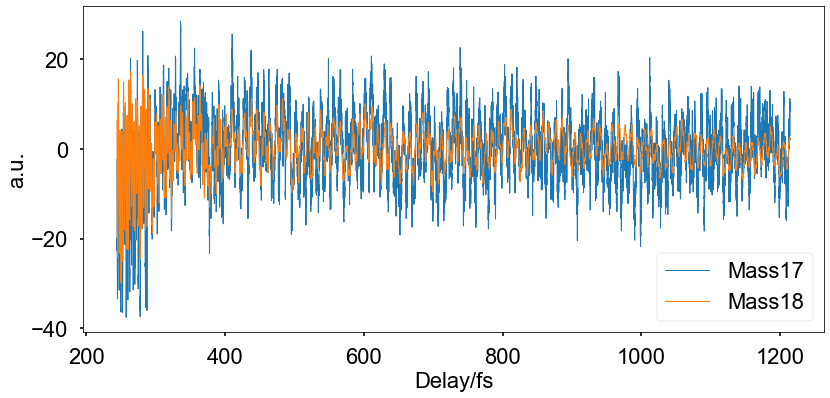

C:\ProgramData\Anaconda3\envs\data\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


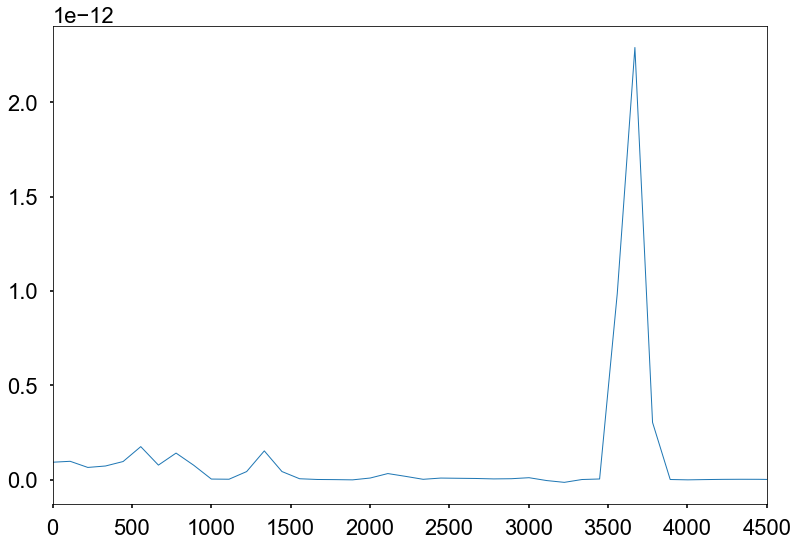

NameError: name 'angle' is not defined

In [31]:
    for x in ff:
        x.pathFinder()
        #print(x.filepath)
        x.read_split()
        
        x.window(windowSize=300, direction='left')
        x.show_Spectra()
        plt.show()
        x.csd('Ch3','Ch4')

        #x.smooth(windowSize=33)
        
        #x.interpS(5)

        
        #x.rebinS(factor=5)
        #x.cwtS(gas='rebin_window_Ch4')
        #x.STFTS(gas='rebin_filter_Ch4', windowsize=int(9.14626*30/1200*2000), ratio=1)
        #x.convolve_sft(gas='rebin_filter_Ch4', frequency=[3650])
        #x.rmvExp()
        
        #x.showRelativePhase()
        #x.showRelativePhaseSingleIon(comFreInCm1=4147,comFreInCm2=3647)
        #plt.show()
        
        #x.rmvExp()
        #
        x.padding(paddingSize=5000)
        x.FFTS()
        x.show_FFT()
            
        #x.show_FFT_comp()
    plt.show()